# Feature Extraction 🌱

## Load Image as Binary

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [8]:
PREPROC_DIR = 'preprocessed_plant_leaves/'
SEGMENTED_DIR = 'segmented/'
label_to_name = {
    '0001' : 'Mango',
    '0007' : 'Pongamia Pinnata',
    '0008' : 'Basil',
    '0010' : 'Lemon'
}

In [9]:
def load_image(file_name):
    cropped = cv2.imread(PREPROC_DIR + file_name)
    segmented = cv2.imread(SEGMENTED_DIR + file_name, cv2.IMREAD_GRAYSCALE)
    return cropped, segmented

In [10]:
file_name = '0007_0026.jpg'
label = file_name[:4]
cropped, segmented = load_image(file_name)
binary_image = (segmented == 1)

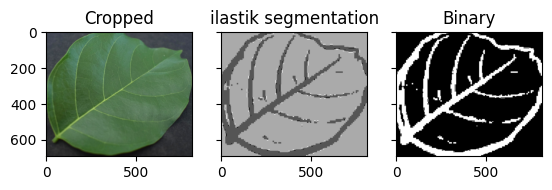

In [154]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex='col', sharey='row')

axs[0].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
axs[0].set_title('Cropped')
axs[1].imshow(segmented, cmap='gray')
axs[1].set_title('ilastik segmentation')
axs[2].imshow(binary_image, cmap='gray')
axs[2].set_title('Binary')

# fig.suptitle(f'Venation extraction \n {label_to_name.get(label)} leaf {file_name}'
plt.tight_layout()
plt.savefig("plots/venationilastik.pdf", format="pdf")
plt.show()

## Skeletonize

https://scikit-image.org/docs/stable/auto_examples/edges/plot_skeleton.html

In [12]:
from skimage.morphology import skeletonize

In [13]:
skeleton = skeletonize(binary_image)

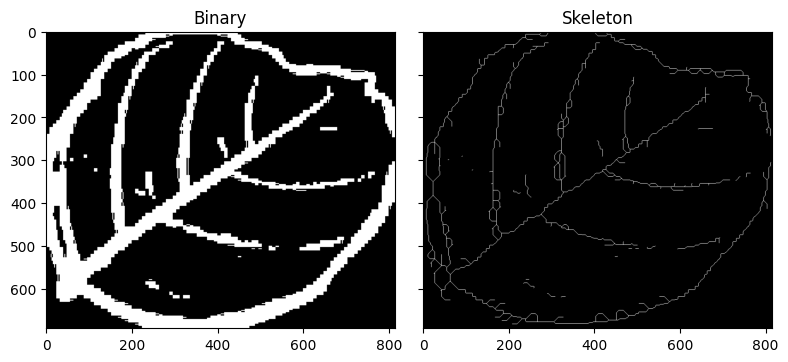

In [136]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8), sharex='col', sharey='row')

axs[0].imshow(binary_image, cmap='gray')
axs[0].set_title('Binary')
axs[1].imshow(skeleton, cmap='gray')
axs[1].set_title('Skeleton')

# fig.suptitle(f'Skeleton \n {label_to_name.get(label)} leaf {file_name}')
plt.tight_layout()
plt.show()

## Convert to Point Cloud 🌥️

In [16]:
def to_point_cloud(binary_image, k=-1, N=-1, log=False):
    """
    Choose amount of points to keep either by proportion or k
    absolute number N.
    
    :param: k: proportion of points to keep
    :param N: number of points to keep
    """
    assert not ((k == -1) and (N == -1)), 'k or n must be set!'
    point_cloud = np.argwhere(binary_image)
    
    if k != -1:
        N = int(point_cloud.shape[0] * k)
    if log:
        print(f'Subset consisting of {N} out of {point_cloud.shape[0]} total points')
    return point_cloud[np.random.choice(point_cloud.shape[0], N, replace=False)], N, point_cloud.shape[0]

In [83]:
# k = 0.015
N = 1000

naive_point_cloud, naive_N, naive_total = to_point_cloud(binary_image, N=N, log=True)
skeleton_point_cloud, skeleton_N, skeleton_total = to_point_cloud(skeleton, N=N, log=True)

Subset consisting of 1000 out of 123847 total points
Subset consisting of 1000 out of 7391 total points


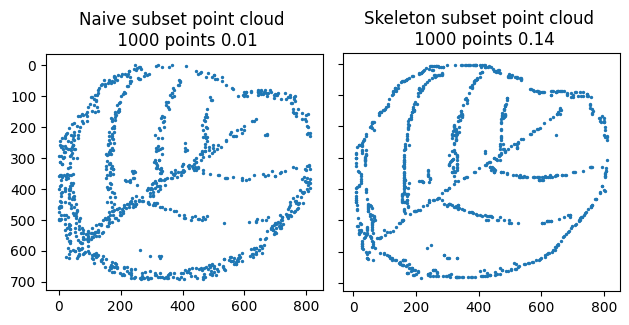

In [158]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row')

y, x = zip(*naive_point_cloud)
axs[0].scatter(x, y, s=2)
axs[0].invert_yaxis()
axs[0].set_aspect('equal')
axs[0].set_title(f'Naive subset point cloud \n {naive_N} points {naive_N/naive_total:.2f}')

y_skel, x_skel = zip(*skeleton_point_cloud)
axs[1].scatter(x_skel, y_skel, s=2)
axs[1].set_aspect('equal')
axs[1].set_title(f'Skeleton subset point cloud \n {skeleton_N} points {skeleton_N/skeleton_total:.2f}')

plt.tight_layout()
plt.show()

## Persistent Homology 🍩

In [85]:
import time

from matplotlib.patches import Circle
from gtda.homology import VietorisRipsPersistence

In [86]:
HOMOLGY_DIMS = [0, 1]
VR = VietorisRipsPersistence(homology_dimensions=HOMOLGY_DIMS)

In [175]:
def plot_persistence_diagram(diagram, dimensions: list, title: str):
    for dim in dimensions:
        diagram_dim = diagram[diagram[:,-1] == dim]  # get values corresponding to dim
        birth_death = [(birth, death) for (birth, death, _) in diagram_dim]
        birth, death = zip(*birth_death)
        plt.scatter(birth, death, label=f'$H_{dim}$')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.xlabel('Birth')
    plt.ylabel('Death')
    X = np.linspace(0, max(max(birth), 256), 2)  # y = x line
    plt.plot(X, X, 'k--')
    plt.gca().set_aspect('equal')
    # plt.savefig("plots/persestencediagram.pdf", format="pdf", bbox_inches='tight')
    plt.show()

In [88]:
reshaped_naive_point_cloud = naive_point_cloud[None, :, :]
reshaped_skeleton_point_cloud = skeleton_point_cloud[None, :, :]

In [89]:
tic = time.time()
naive_diagrams = VR.fit_transform(reshaped_naive_point_cloud)
toc = time.time()
print(f'Done. Elapsed time: {toc - tic} seconds')

Done. Elapsed time: 0.33483409881591797 seconds


In [90]:
tic = time.time()
skeleton_diagrams = VR.fit_transform(reshaped_skeleton_point_cloud)
toc = time.time()
print(f'Done. Elapsed time: {toc - tic} seconds')

Done. Elapsed time: 0.416043758392334 seconds


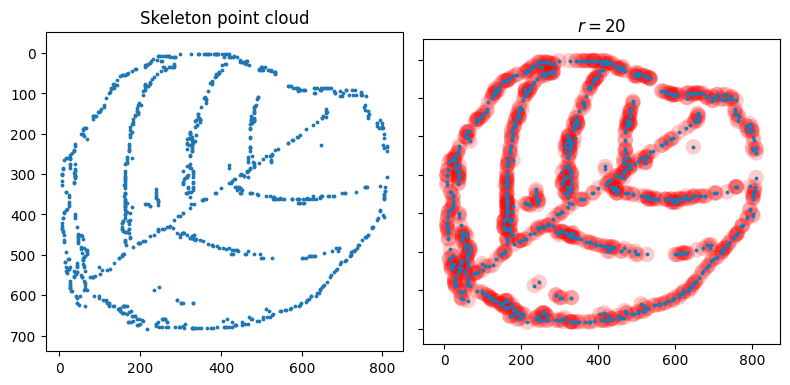

In [139]:
r = 20

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8), sharex='col', sharey='row')
y, x = zip(*skeleton_point_cloud)
axs[0].scatter(x, y, s=3)
axs[0].invert_yaxis()
axs[0].set_aspect('equal')
axs[0].set_title('Skeleton point cloud')

for point in skeleton_point_cloud:
    circle = Circle((point[1], point[0]), radius=r, facecolor='r', alpha=0.2)
    axs[1].add_patch(circle)
axs[1].set_aspect('equal')
axs[1].scatter(x, y, s=3)
axs[1].set_title(f'$r={r}$')

plt.tight_layout()

plt.show()

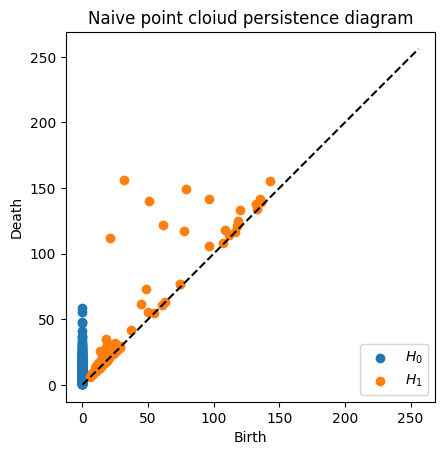

In [111]:
plot_persistence_diagram(naive_diagrams[0], HOMOLGY_DIMS, 'Naive point cloiud persistence diagram')

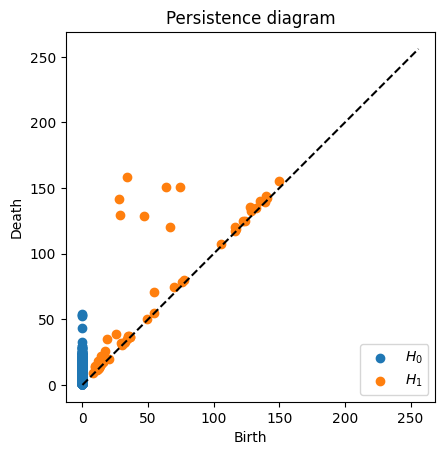

In [173]:
plot_persistence_diagram(skeleton_diagrams[0], HOMOLGY_DIMS, 'Persistence diagram')

## Feature Extraction using Persistent Entropy

The [persitent homology](https://giotto-ai.github.io/gtda-docs/latest/theory/glossary.html#persistence-entropy) of a diagram is the [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory) of the points in the diagram.

In [113]:
from gtda.diagrams import PersistenceEntropy

In [114]:
PE = PersistenceEntropy()
naive_pe = PE.fit_transform(naive_diagrams)
skeleton_pe = PE.fit_transform(skeleton_diagrams)
print('naive PE:\t' + str(naive_pe[0]))
print('skeleton PE:\t' + str(skeleton_pe[0]))

naive PE:	[9.68664939 5.20689745]
skeleton PE:	[9.50317359 4.0271918 ]


### k-dependence

k is the only parameter in our venation extraction scheme (beyond the ilastik model), ideally we would like to choose k large enough so that our results depend not on it. 

In [115]:
from tqdm.notebook import tqdm

In [32]:
k_naive = [0.05, 0.04, 0.03, 0.02, 0.01]

k_naive_PE = []
k_naive_time = []

for k in tqdm(k_naive):
    naive_point_cloud, naive_N, naive_total = to_point_cloud(binary_image, k=k)
    reshaped_naive_point_cloud = naive_point_cloud[None, :, :]
    
    tic = time.time()
    naive_diagrams = VR.fit_transform(reshaped_naive_point_cloud)
    k_naive_PE.append((k, PE.fit_transform(naive_diagrams)[0]))
    toc = time.time()

    k_naive_time.append((k, toc-tic))

  0%|          | 0/5 [00:00<?, ?it/s]

In [42]:
k_skeleton = [0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01]

k_skeleton_PE = []
k_skeleton_time = []

for k in tqdm(k_skeleton):
    skeleton_point_cloud, skeleton_N, skeleton_total = to_point_cloud(skeleton, k=k)
    reshaped_skeleton_point_cloud = skeleton_point_cloud[None, :, :]
    
    tic = time.time()
    skeleton_diagrams = VR.fit_transform(reshaped_skeleton_point_cloud)
    k_skeleton_PE.append((k, PE.fit_transform(skeleton_diagrams)[0]))
    toc = time.time()

    k_skeleton_time.append((k, toc-tic))

  0%|          | 0/11 [00:00<?, ?it/s]

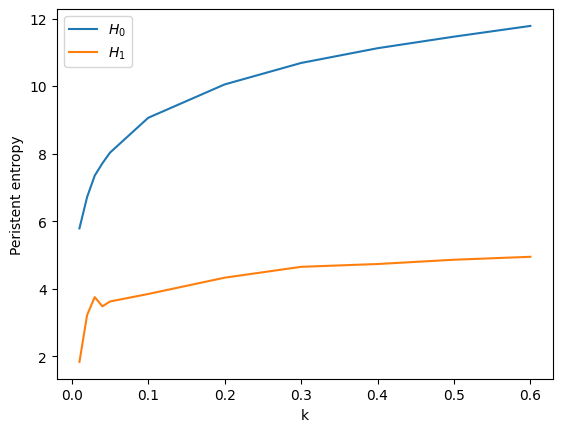

In [179]:
k_naive_H0 = [(k, H0) for (k, (H0, _)) in k_naive_PE]
k_naive_H1 = [(k, H1) for (k, (_, H1)) in k_naive_PE]
k_skeleton_H0 = [(k, H0) for (k, (H0, _)) in k_skeleton_PE]
k_skeleton_H1 = [(k, H1) for (k, (_, H1)) in k_skeleton_PE]

# plt.plot(*zip(*k_naive_H0), '-', label='$H_0$ PE naive')
# plt.plot(*zip(*k_naive_H1), '-', label='$H_1$ PE naive')
plt.plot(*zip(*k_skeleton_H0), '-', label='$H_0$')
plt.plot(*zip(*k_skeleton_H1), '-', label='$H_1$')

plt.ylabel('Peristent entropy')
plt.xlabel('k')
# plt.title(f'Persistent entropy depenence on k \n {label_to_name.get(label)} leaf {file_name}')
plt.legend()
plt.savefig("plots/pedependenceonk.pdf", format="pdf", bbox_inches='tight')
plt.show()

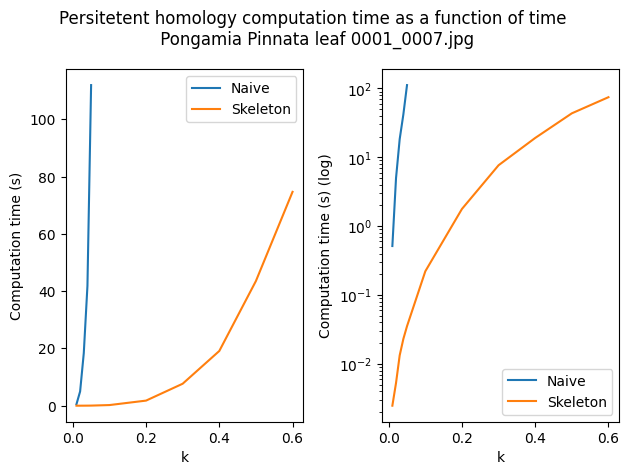

In [148]:
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(*zip(*k_naive_time), '-', label='Naive')
axs[0].plot(*zip(*k_skeleton_time), '-', label='Skeleton')
axs[0].legend()
axs[0].set_xlabel('k')
axs[0].set_ylabel('Computation time (s)')

axs[1].plot(*zip(*k_naive_time), '-', label='Naive')
axs[1].plot(*zip(*k_skeleton_time), '-', label='Skeleton')
axs[1].legend()
axs[1].set_xlabel('k')
axs[1].set_ylabel('Computation time (s) (log)')
# plt.xscale('log')
axs[1].set_yscale('log')

plt.suptitle(f'Persitetent homology computation time as a function of time \n {label_to_name.get(label)} leaf {file_name}')
plt.tight_layout()
plt.show()

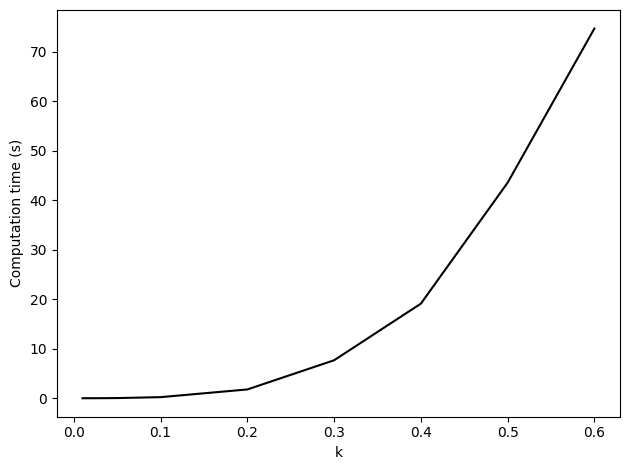

In [184]:
plt.plot(*zip(*k_skeleton_time), 'k-')
plt.xlabel('k')
plt.ylabel('Computation time (s)')

# plt.suptitle(f'Persitetent homology computation time as a function of time \n {label_to_name.get(label)} leaf {file_name}')
plt.tight_layout()
plt.savefig("plots/pecomputationtimedependenceonk.pdf", format="pdf", bbox_inches='tight')
plt.show()

Based on this, we choose `k=0.2`. 

In [118]:
k = 0.2

## Persistent Entropy All

In [119]:
import glob
import os
import csv

import pandas as pd

Get file names for all leaves and compute entorpy for each leaf

In [121]:
file_paths = glob.glob(SEGMENTED_DIR + "/*.jpg")
file_names = [os.path.basename(file_name) for file_name in file_paths]

In [129]:
def skeleton_persistent_entropy(file_name, k):
    segmented = cv2.imread(SEGMENTED_DIR + file_name, cv2.IMREAD_GRAYSCALE)
    binary_image = (segmented == 1)
    skeleton = skeletonize(binary_image)
    skeleton_point_cloud, _, _ = to_point_cloud(skeleton, k=k)
    skeleton_reshaped_point_cloud = skeleton_point_cloud[None, :, :]
    skeleton_diagrams = VR.fit_transform(skeleton_reshaped_point_cloud)
    return PE.fit_transform(skeleton_diagrams)[0]

In [130]:
skeleton_entropies = []
labels = []
for file_name in tqdm(file_names):
    pe = skeleton_persistent_entropy(file_name, k)
    skeleton_entropies.append(pe)
    labels.append(int(file_name[:4]))
    print(f'{file_name} {pe}')

  0%|          | 0/160 [00:00<?, ?it/s]

0001_0022.jpg [10.83061674  6.03260729]
0001_0036.jpg [10.677257    5.85260866]
0010_0040.jpg [9.50969041 3.1423385 ]
0001_0037.jpg [10.24245153  5.73780021]
0001_0023.jpg [10.47447809  5.77861193]
0001_0009.jpg [10.77322567  6.13221253]
0001_0035.jpg [10.64734392  5.78988652]
0001_0021.jpg [10.62381981  6.13405278]
0001_0020.jpg [10.9219735   6.55319678]
0001_0034.jpg [10.11231302  5.48096839]
0001_0008.jpg [10.60914437  5.82449565]
0001_0030.jpg [10.05697961  5.01529746]
0001_0024.jpg [10.85501856  6.2965177 ]
0001_0018.jpg [10.15184588  5.97389787]
0007_0040.jpg [9.72832441 3.76535286]
0001_0019.jpg [10.49558539  5.80515713]
0001_0025.jpg [10.58486043  5.94568163]
0001_0031.jpg [10.5640189   5.77281924]
0001_0027.jpg [10.53404496  5.77833789]
0001_0033.jpg [10.31116366  5.85337809]
0001_0032.jpg [10.78545017  6.11069178]
0001_0026.jpg [10.74496754  6.07953347]
0007_0024.jpg [9.40630293 3.49129764]
0007_0030.jpg [10.07362171  5.09971815]
0007_0018.jpg [9.5466866 3.4139199]
0010_0036.

## Save as CSV 📥

In [133]:
csv_file_name = 'plant_species_entropy/ilastik_skeletonize.csv'

data = list(zip(labels, skeleton_entropies))

with open(csv_file_name, mode='w+', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Species', 'H0', 'H1'])
    for row in data:
        writer.writerow([row[0], *row[1]])

In [134]:
df = pd.read_csv(csv_file_name)
df.head()

,Species,H0,H1
0,1,10.830617,6.032607
1,1,10.677257,5.852609
2,10,9.509690,3.142338
3,1,10.242452,5.737800
4,1,10.474478,5.778612
